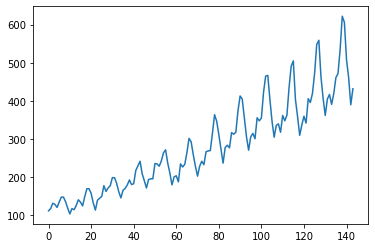

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#%matplotlib inline

data = pd.read_csv('AirPassengers.csv')
ts = data['#Passengers']
plt.plot(ts)

可以使用seasonal_decompose()进行分析，将时间序列分解成长期趋势项(Trend)、季节性周期项(Seansonal)和残差项(Resid)这三部分。

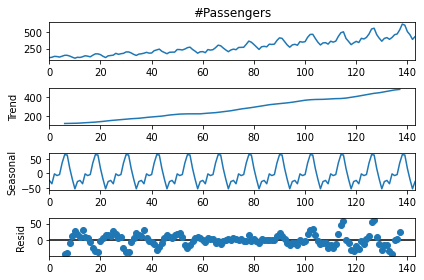

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_decomposition = seasonal_decompose(ts, freq=12)
ts_decomposition.plot()
plt.show()

In [20]:
from statsmodels.tsa.stattools import adfuller                 # ADF检验
def stableCheck(timeseries):
    # 移动12期的均值和方差
    rol_mean = timeseries.rolling(window=12).mean()
    rol_std = timeseries.rolling(window=12).std()
    # 绘图
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rol_mean, color='red', label='Rolling Mean')
    std = plt.plot(rol_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # 进行ADF检验
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # 对检验结果进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print('ADF检验结果:')
    print(dfoutput)


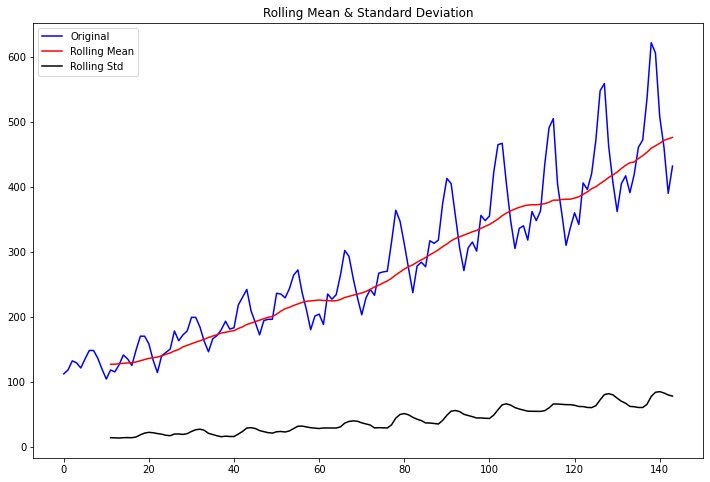

Results of Dickey-Fuller Test:
ADF检验结果:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [21]:
stableCheck_result1 = stableCheck(ts)

ADF检验的原假设就是存在单位根，如果得到的显著性检验统计量小于三个置信度（10%，5%，1%），则对应有（90%，95，99%）的把握来拒绝原假设。有以下两种方式来判断：
      （1）这里将Test Statistic与1%、%5、%10不同程度拒绝原假设的统计值进行比较。当ADF Test result 同时小于 1%、5%、10%即说明非常好地拒绝该假设。本数据中，0.815369并没有都小于三个level的统计值，所以判断为该时间序列time series非平稳。
      （2）观察p-value，是否非常接近于0。这里p-value约为0.99>0.05，因此不能拒绝原假设

对于非平稳时间序列，可以通过d阶差分运算使变成平稳序列。从统计学角度来讲，只有平稳性的时间序列才能避免“伪回归”的存在，才有经济意义。
      在这里，我先进行了一阶差分，再进行了一次季节性差分，才通过ADF检验。

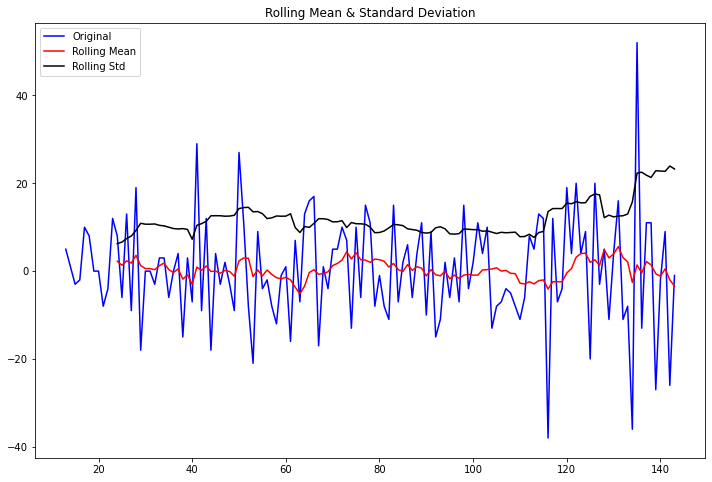

Results of Dickey-Fuller Test:
ADF检验结果:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [26]:
# 差分处理非平稳序列，先进行一阶差分
ts_diff_1 = ts.diff(1).dropna()
# 在一阶差分基础上进行季节性差分差分
ts_diff_2 = ts_diff_1.diff(12).dropna()
stableCheck_result2 = stableCheck(ts_diff_2)


接下来，对d阶差分后的的平稳序列进行白噪声检验.
 Ljung-Box检验

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def whiteNoiseCheck(data):
    result = acorr_ljungbox(data, lags=1)
    temp = result[1]
    print('白噪声检验结果：', result)
    # 如果temp小于0.05，则可以以95%的概率拒绝原假设，认为该序列为非白噪声序列；否则，为白噪声序列，认为没有分析意义
    print(temp)
    return result


In [32]:
ifwhiteNoise = whiteNoiseCheck(ts_diff_2)

白噪声检验结果： (array([12.8642202]), array([0.00033492]))
[0.00033492]


0.00033<0.05，可以以95%的概率拒绝原假设，认为该序列为非白噪声序列。

做自相关函数图和偏自相关函数图，确定模型阶次。使用 statsmodels 库提供的作图方法——acf和pacf做相关的图：

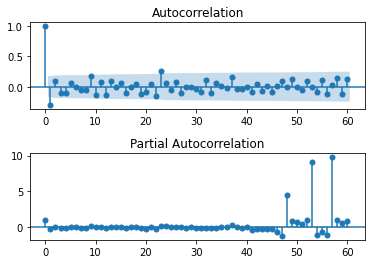

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.ticker import MultipleLocator
def draw_acf(data):
    # 利用ACF判断模型阶数
    plot_acf(data)
    plt.title("序列自相关图(ACF)")
    plt.show()

def draw_pacf(data):
    # 利用PACF判断模型阶数
    plot_pacf(data)
    plt.title("序列偏自相关图(PACF)")
    plt.show()
    
def draw_acf_pacf(data):
    f = plt.figure(facecolor='white')
    # 构建第一个图
    ax1 = f.add_subplot(211)
    # 把x轴的刻度间隔设置为1，并存在变量里
    x_major_locator = MultipleLocator(10)
    plot_acf(data, ax=ax1, lags=60)
    # 构建第二个图
    ax2 = f.add_subplot(212)
    plot_pacf(data, ax=ax2, lags=60)
    plt.subplots_adjust(hspace=0.5)
    # 把x轴的主刻度设置为10的倍数
    ax1.xaxis.set_major_locator(x_major_locator)
    ax2.xaxis.set_major_locator(x_major_locator)
    plt.show()

draw_acf_pacf(ts_diff_2)

使用了pmdarima.auto_arima()方法构建ARIMA模型及预测。这个方法可以帮助我们自动确定ARIMA(p,d,q)(P,D,Q)_m
的参数，也就是可以直接跳过上述步骤，直接输入数据，设置auto_arima()中的参数则可。
 
   之前我们是通过观察ACF、PACF图的拖尾截尾现象来定阶，但是这样可能不准确。实际上，往往需要结合图像拟合多个模型，通过模型的AIC、BIC值以及残差分析结果来选择合适的模型。


In [53]:
import pmdarima as pm
split_point = int(len(ts) * 0.85)
# 确定训练集/测试集
data_train, data_test = ts[0:split_point], ts[split_point:len(ts)]
# 使用训练集的数据来拟合模型
built_arimamodel = pm.auto_arima(data_train,
                                 start_p=0,   # p最小值
                                 start_q=0,   # q最小值
                                 test='adf',  # ADF检验确认差分阶数d
                                 max_p=5,     # p最大值
                                 max_q=5,     # q最大值
                                 m=12,        # 季节性周期长度，当m=1时则不考虑季节性
                                 d=None,      # 通过函数来计算d
                                 seasonal=True, start_P=0, D=1, trace=True,
                                 error_action='ignore', suppress_warnings=True,
                                 stepwise=False  # stepwise为False则不进行完全组合遍历
                                 )
print(built_arimamodel.summary())


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=824.162, Time=0.38 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=825.089, Time=0.20 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=826.611, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=824.958, Time=0.08 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=826.853, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=826.739, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.94 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=820.279, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=821.848, Time=0.11 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=822.164, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=821.730, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,1)(2,1,0)[12]      

图中设置黄色（浅色）绘制原波形，蓝色（深色）绘制拟合后的波形.上面程序拟合的是差分后的波形，用以下方法将其转换回原始波形：

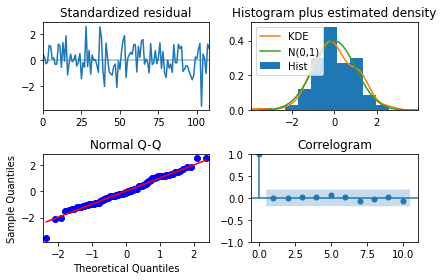

In [55]:
built_arimamodel.plot_diagnostics()
plt.tight_layout()
plt.show()

In [59]:
# 进行多步预测,再与测试集的数据进行比较
pred_list = []
for index, row in data_test.iteritems():
    # 输出索引，值
    # print(index, row)
    pred_list += [built_arimamodel.predict(n_periods=1)]
    # 更新模型，model.update()函数，不断用新观测到的 value 更新模型
    built_arimamodel.update(row)
    # 预测时间序列以外未来的一次
    predict_f1 = built_arimamodel.predict(n_periods=1)
    print('未来一期的预测需求为：', predict_f1[0])


未来一期的预测需求为： 387.13597362285645
未来一期的预测需求为： 406.4214357609544
未来一期的预测需求为： 484.04821158804015
未来一期的预测需求为： 526.3030434830221
未来一期的预测需求为： 551.0535237333291
未来一期的预测需求为： 460.6438644059991
未来一期的预测需求为： 415.1731529929835
未来一期的预测需求为： 355.69362438918716
未来一期的预测需求为： 385.23915946822706
未来一期的预测需求为： 426.0294524205768
未来一期的预测需求为： 402.8248739359643
未来一期的预测需求为： 451.92172379473675
未来一期的预测需求为： 413.35972042197886
未来一期的预测需求为： 472.70168003727156
未来一期的预测需求为： 540.0412215131767
未来一期的预测需求为： 599.6719792812873
未来一期的预测需求为： 625.3525613363345
未来一期的预测需求为： 518.7828746290899
未来一期的预测需求为： 449.21218426883877
未来一期的预测需求为： 413.9874125785153
未来一期的预测需求为： 446.3065866403635
未来一期的预测需求为： 445.0273613811014


In [60]:
# ARIMA模型评价
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    # rmse = np.mean((forecast - actual)**2)**0.5    # RMSE
    rmse_1 = np.sqrt(sum((forecast - actual) ** 2) / actual.size)
    corr = np.corrcoef(forecast, actual)[0, 1]
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    return ({'mape': mape,
             'me': me,
             'mae': mae,
             'mpe': mpe,
             'rmse': rmse_1,
             'corr': corr,
             'minmax': minmax
             })


模型评价结果
 {'mape': 0.03300470600311517, 'me': -1.5025715868528173, 'mae': 14.97254899294853, 'mpe': -0.0025711369603876283, 'rmse': 18.232337675361933, 'corr': 0.9673574180266401, 'minmax': 0.032357149009616726}


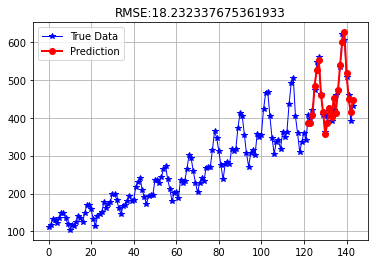

In [62]:
# 画图观测实际与测试的对比
test_predict = data_test.copy()
for x in range(len(test_predict)):
    test_predict.iloc[x] = pred_list[x]
# 模型评价
eval_result = forecast_accuracy(test_predict.values, data_test.values)
print('模型评价结果\n', eval_result)
# 画图显示
plt.plot(ts, 'b-', lw=1, label='True Data', marker='*')
plt.plot(test_predict, 'r-', lw=2, label='Prediction', marker='o')
plt.title('RMSE:{}'.format(eval_result['rmse']))
plt.legend(loc='best')
plt.grid()  # 生成网格
plt.show()
